Affronteremo un problema di Classificazione.
![](image/02_classification.png)

Un problema di classificazione comprende il predire se un qualcosa appartiene a una "categoria" o un'altra

| Problem type | What is it? | Example|
|--------------|--------------|------|
| Binary classification | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters.|
| Multi-class classification | Target can be one of more than two options | Decide whether a photo is of food, a person or a dog.|
| Multi-label classification | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy).|

Il barch size sarà di 32 ([tweet LeCun](https://x.com/ylecun/status/989610208497360896))
![](image/Lecun_batch.png)


## Architettura di un rete neurale di classificazione

| **Hyperparameter** | **Binary Classification** | **Multiclass classification**|
|----------------|-----------------------|---------------------------|
|**Input layer shape** (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification|
|**Hidden layer(s)** | Problem specific, `minimum = 1`, `maximum = unlimited` | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification|
| **Output layer shape** (out_features) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo)|
| **Hidden layer activation** | Usually `ReLU` (rectified linear unit) but can be many others | Same as binary classification|
| **Output activation** | Sigmoid (`torch.sigmoid` in PyTorch) | Softmax (`torch.softmax` in PyTorch)|
| **Loss function** | Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch)|
| **Optimizer** | 	SGD (stochastic gradient descent), Adam (see `torch.optim` for more options) | Same as binary classification|

# 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make dataframe of circle data

import pandas as pd
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label":y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [57]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

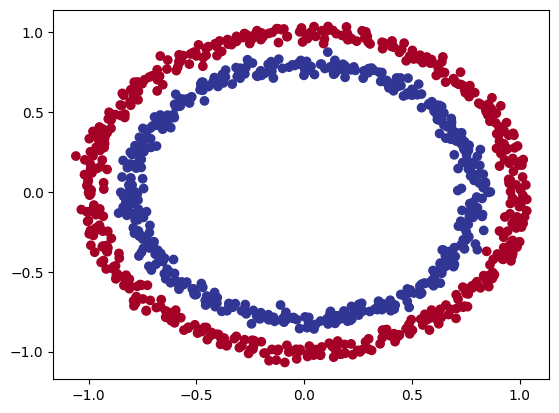

In [7]:
# Visualize visualize visualize
import matplotlib.pyplot as plt
plt.scatter(
    x = X[:,0],
    y = X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

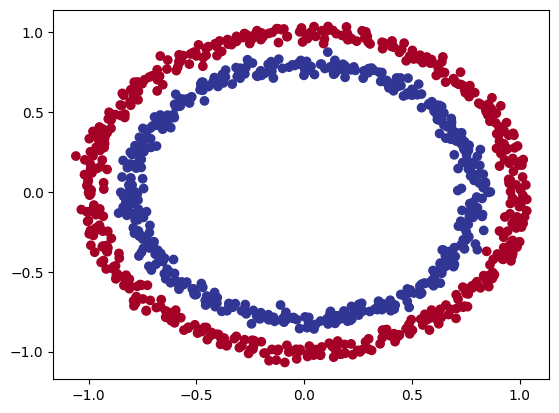

In [10]:
# Visualize visualize visualize (test con il dataframe)
import matplotlib.pyplot as plt
plt.scatter(
    x=circles["X1"],
    y=circles["X2"],
    c=circles["label"],
    cmap=plt.cm.RdYlBu
);

**Nota**: I dati con cui stiamo lavorando spesso vengono chiamati **toy dataset**, ovvero dataset piccoli per poter sperimentare ma della dimensione giusta per fare pratica.

### 1.1 Controllo della forma degli input e output
Abbiamo 1000 samples, con 2 feature per gli input e 1000 output con un unico valore

In [11]:
X.shape, y.shape

((1000, 2), (1000,))

In [12]:
# Visualizziamo il primo esempio di feature e label
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X (2,) and the same for y: ()


### 1.2 Convertire dati in tensori e creare train and test splits

In [14]:
import torch

torch.__version__

'2.7.0'

In [16]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [17]:
# Turn data into tensor
X = torch.from_numpy(X).type(torch.float) # float 32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [20]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

1. setup device agnostic code (GPU or CPU)
2. Construct a model (subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create training and test loop

In [22]:
import torch
from torch import nn

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Poi usa
device = get_device()


In [23]:
print(device)

mps


Dopo aver imopstato il codice in modo *device agnostic*:
1. Subclass di `nn.Module`
2. Creare 2 layer `nn.Linear()` in modo tale da poter gestire la forma dei nostri dati
3. Definire un metodo `forward()` per effetturare il forward pass del modello
4. Instanziare un istanza della classe modello e mandarla sul `device` target
    

In [24]:
# 1 subclass
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 crere 2 layer in modo da poter gestire la forma dei dati
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # out feature di solito multipli di 8 (upscaliamo per poter avere più patter per far imparare il modello)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # prende le 5 feature del layer precedente e ne butta fuori 1 come output
    # 3 forward method per effetture il forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4 istanziare e mandare il modello sul device target
model_0 = CircleModelV0().to(device)

model_0
        
    

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
device

device(type='mps')

In [26]:
next(model_0.parameters()).device

device(type='mps', index=0)

Esempio visuale di cosa fare grazie al [Playground di TensorFlow](https://playground.tensorflow.org/)

Nel primo layer abbiamo impostato il ricevere 2 features come input e ne generiamo 5, quindi facciamo un **upscaling**.
Questo permette al modello di imparare pattern da 5 numeri e non da soli 2 numeri, per avere potenzialmente migliori output.

**Il numero di hidden layers** che possiamo usare in una rete neurale viene definito **hyperparameter** in quanto viene impostato da noi.
**Regola** con gli hidden layer, il layer successivo dovrà prendere come `in_feature` lo stesso numero di `out_features` del layer che lo precede.


![](image/02-tensorflow-playground-linear-activation.png)



**Possiamo ottenere lo stesso risultato usando `nn.Sequential()`**

Che permette di implementare senza creare la subclass. Ma il subclassing ci permette di gestire meglio le cose.

In [28]:
model_0_S = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_S

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

**Per vedere i pesi e bias randomizzati iniziali:**

In [30]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5280, -0.6383],
                      [ 0.0182, -0.1084],
                      [-0.5489,  0.6305],
                      [-0.5932,  0.1968],
                      [-0.1812,  0.6512]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.1380, -0.6508, -0.1989, -0.4496, -0.0237], device='mps:0')),
             ('layer_2.weight',
              tensor([[-0.3610,  0.2223, -0.4369,  0.0717,  0.4019]], device='mps:0')),
             ('layer_2.bias', tensor([-0.3328], device='mps:0'))])

In [33]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test sample: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test sample: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.3612],
        [-0.1792],
        [-0.6719],
        [-0.2738],
        [-0.4079],
        [-0.2988],
        [ 0.0043],
        [-0.0230],
        [-0.6825],
        [-0.1641]], device='mps:0')

First 10 labels labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Per un problema di **classificazione** non possiamo usare la metrica usata per la **regressione (MAE O MSE)**, molto probabilmente useremo la **binary cross entropy** o la **categorical Cross entropy**


| **Loss function/Optimizer** | **Problem type** | **PyTorch Code** |
|--------------------------|-------------|--------------|
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()` |
| Adam Optimizer | Classification, regression, many others. | `torch.optim.Adam()` |
| Binary cross entropy loss | Binary classification | `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss` |
| Cross entropy loss | Multi-class classification | `torch.nn.CrossEntropyLoss` |
| Mean absolute error (MAE) or L1 Loss | Regression | `torch.nn.L1Loss` |
| Mean squared error (MSE) or L2 Loss | Regression | `torch.nn.MSELoss` |


### Useremo `BCEWithLogitsLoss`
Vantaggi di BCEWithLogitsLoss

1. Stabilità numerica:

- `BCEWithLogitsLoss` combina in un'unica funzione l'attivazione sigmoide e la loss Binary Cross Entropy (BCE)
- Questa combinazione è implementata in modo numericamente più stabile rispetto all'applicazione separata di sigmoid e BCE


2. Maggiore efficienza:

- Evita il calcolo intermedio dell'attivazione sigmoide, ottimizzando le operazioni
- È più veloce perché utilizza trucchi matematici per calcolare direttamente la loss dai logits


3. Prevenzione di problemi di overflow/underflow:

- I valori molto grandi o molto piccoli nei logits possono causare problemi numerici quando si applica la sigmoide separatamente
- `BCEWithLogitsLoss` gestisce internamente questi casi limite


4. Supporto per pesi per classi sbilanciate:

- Permette di specificare facilmente pesi per gestire dataset sbilanciati
- È possibile passare un parametro `pos_weight` per dare più importanza alla classe positiva


5. Migliore per il backpropagation:

-Il gradiente è calcolato in modo più preciso, il che migliora l'apprendimento



- Esempio pratico
Ecco la differenza tra l'approccio separato e l'uso di `BCEWithLogitsLoss`:
- Approccio separato (meno stabile):
```
# Definizione del modello senza sigmoide finale
outputs = model(inputs)  # outputs sono logits (valori non normalizzati)
probs = torch.sigmoid(outputs)  # Applicazione della sigmoide
loss_fn = nn.BCELoss()  # Binary Cross Entropy normale
loss = loss_fn(probs, targets)  # Calcolo della loss
```
- Approccio con BCEWithLogitsLoss (più stabile):

```
# Definizione del modello senza sigmoide finale
outputs = model(inputs)  # outputs sono logits (valori non normalizzati)
loss_fn = nn.BCEWithLogitsLoss()  # Sigmoide + BCE in un'unica funzione
loss = loss_fn(outputs, targets)  # Calcolo diretto della loss dai logits
```


In [52]:
loss_fn = nn.BCEWithLogitsLoss() # ha già l'attivazione sigomoide

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Calculate accuracy

$\text{Accuracy}=\frac{\text{Numero di predizioni corrette}}{\text{Numero totale di predizioni}} ×100$

Ci dice su tot esempi, quale percentuale il nostro modello ha indovinato

In [51]:
def acuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3 Train a model
- Training Loop
  1. forward pass,
  2. calculate the loss,
  3. zero grad,
  4. backpropagation,
  5. optimizer

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

I **raw logits** sono i valori di output non elaborati prodotti dall'ultimo strato di una rete neurale, prima che venga applicata qualsiasi funzione di attivazione finale (come sigmoid, softmax, ecc.).

Caratteristiche dei raw logits:

- **Non normalizzati**: Sono valori numerici che possono variare da `-∞ a +∞`, senza limiti di intervallo specifici
- **Non interpretabili come probabilità**: Non sono confinati nell'intervallo `[0,1]`, quindi non possono essere direttamente interpretati come probabilità
- **Rappresentano "fiducia" grezza**: Valori più alti (positivi) indicano maggiore confidenza del modello verso una classe, valori più bassi (negativi) indicano confidenza verso la classe opposta

COnvertiremo i raw **logits** in prediction probabilities tramite una funzione di attivazione ( **sigmoide** per binary cross entropy, **softmax** per una multiclass classification.

Dopo convertiremo le predizioni di probabilità a **prediction labels** o arrotondandole o con `argmax()`

In [46]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:10]
y_logits

tensor([[-0.3612],
        [-0.1792],
        [-0.6719],
        [-0.2738],
        [-0.4079],
        [-0.2988],
        [ 0.0043],
        [-0.0230],
        [-0.6825],
        [-0.1641]], device='mps:0')

In [47]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [48]:
# Use the sigmoid activaction function on our model logits to turn into predictions probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4107],
        [0.4553],
        [0.3381],
        [0.4320],
        [0.3994],
        [0.4258],
        [0.5011],
        [0.4942],
        [0.3357],
        [0.4591]], device='mps:0')

Per i valori in probabilità dobbiamo performare un rounding:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [49]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full (logits -> pre probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:10]))

# Check for quality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True],
       device='mps:0')


tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='mps:0')

In [50]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

### 3.2 Building and training and testing loop

In [55]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

# set numbero epochs
epochs = 100

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)

X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and eval loop

for epoch in range(epochs):
    ### tDeprecationWarning
    model_0.train()

    # 1 forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2 calculate loss / accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() si aspettta raw logits come input
                   y_train)
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss si aspettta prediction probabilities come input
    #              y_train)

    acc = acuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backward (back propagation)
    loss.backward()
    
    # 5 optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1 forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2 calculate test loss / acc 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # print out what is happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71689, Acc: 49.25% | Test Loss: 0.72328, Test acc: 45.50%
Epoch: 10 | Loss: 0.70468, Acc: 46.00% | Test Loss: 0.71224, Test acc: 49.00%
Epoch: 20 | Loss: 0.69995, Acc: 47.75% | Test Loss: 0.70758, Test acc: 48.00%
Epoch: 30 | Loss: 0.69777, Acc: 48.62% | Test Loss: 0.70510, Test acc: 49.00%
Epoch: 40 | Loss: 0.69656, Acc: 49.50% | Test Loss: 0.70347, Test acc: 48.50%
Epoch: 50 | Loss: 0.69576, Acc: 49.88% | Test Loss: 0.70223, Test acc: 48.50%
Epoch: 60 | Loss: 0.69519, Acc: 50.25% | Test Loss: 0.70122, Test acc: 48.50%
Epoch: 70 | Loss: 0.69475, Acc: 50.12% | Test Loss: 0.70038, Test acc: 48.50%
Epoch: 80 | Loss: 0.69441, Acc: 50.12% | Test Loss: 0.69967, Test acc: 48.00%
Epoch: 90 | Loss: 0.69413, Acc: 50.12% | Test Loss: 0.69907, Test acc: 48.50%


## 4 Make predictions and evaluate the model

Dalle metriche il nostro modello non sta imparando **una cippa**. un accuracy del 50% equivale a tirare a indovinare....

Proviamo a fare delle predizioni e renderle visivamente

Per farlo importiamo una funzione chiamata `plot_decision_boundary()` dalla repo del corso https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [59]:
import requests
from pathlib import Path


# download 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
    

Download helper_functions.py


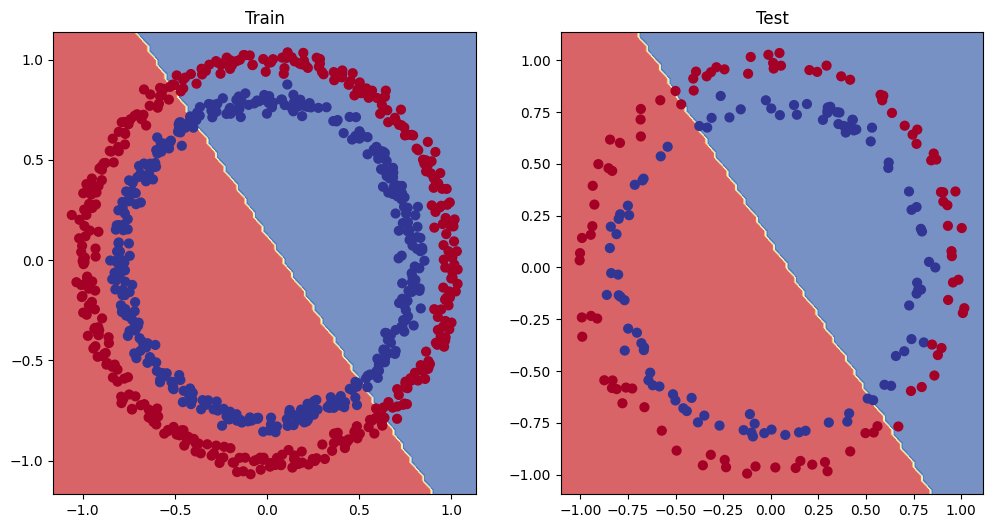

In [61]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


Dal grafico capiamo il problema, il modello sta cercando di fare previsioni solo con layer lineari.

### 5 Improving a model (from a model perspective)
- Add **more layers** - dare al modello più possibilità di imparare sui patterns nei dati
- Add **more hidden units** - da 5 unità nascoste a 10 unità nascoste.
- **Fit for longer** (aumentare epochs)
- Changing the **activation functions** (combinare i layer lineari con le funzioni di attivazioni es ReLU)
- Change the **learning rate**
- Change the **loss function**


| **Model improvement technique** | **What does it do?**|
|-----------------------------------|---------------------|
| **Add more layers** | Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data. More layers are often referred to as making your neural network deeper.|
| **Add more hidden units** | Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model. More hidden units are often referred to as making your neural network wider.|
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data.|
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).|
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.|
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.|
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem.|


Tutte queste opzioni sono da una "prospettiva" del modello in quanto sono direttamente legate ad esso  piuttosto che ai dati.

E anche perché queste opzioni sono tutti valori che(come machine learning enigneers e data scientist) possiamo cambiare, e vengono definiti **Iperparametri**

In [63]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 =  nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(x)
        # z = self.layer_3(x)
    # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

model_1
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222,

In [64]:
next(model_1.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802]], device='mps:0', requires_grad=True)

In [66]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1)

In [67]:
# Write a trininig and evaluation loop for model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### training
    model_1.train()
    # 1 forward
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred labels

    # 2 loss
    loss = loss_fn(y_logits, y_train)
    acc = acuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        acc = acuracy_fn(y_true=y_test, y_pred=test_pred)


    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Accuracy : {acc:.2f}% | test loss: {test_loss:.5f} | Test acc {test_acc:.2f}%")
        


Epoch 0 | Loss: 0.69396 | Accuracy : 51.00% | test loss: 0.69261 | Test acc 48.50%
Epoch 100 | Loss: 0.69305 | Accuracy : 48.00% | test loss: 0.69379 | Test acc 48.50%
Epoch 200 | Loss: 0.69299 | Accuracy : 46.00% | test loss: 0.69437 | Test acc 48.50%
Epoch 300 | Loss: 0.69298 | Accuracy : 45.00% | test loss: 0.69458 | Test acc 48.50%
Epoch 400 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69465 | Test acc 48.50%
Epoch 500 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69467 | Test acc 48.50%
Epoch 600 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 700 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 800 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%
Epoch 900 | Loss: 0.69298 | Accuracy : 46.00% | test loss: 0.69468 | Test acc 48.50%


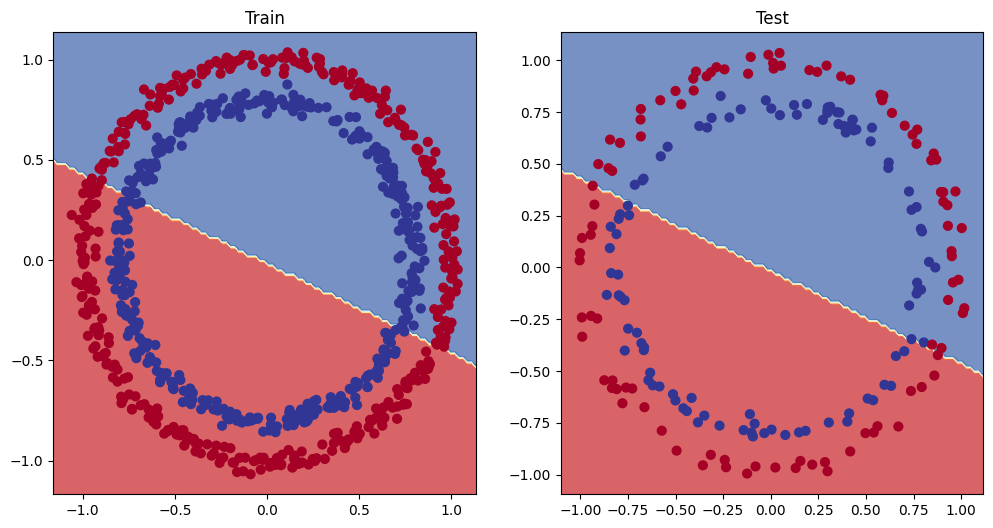

In [68]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to ssee if our model can fit a straight line

Giustamente il modello continua a non imparare perché non stiamo facendo altro che una regressione.....

In [69]:
# Create some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias 

# check the data
print(len(X_regression))

X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [70]:
# create train and test split

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

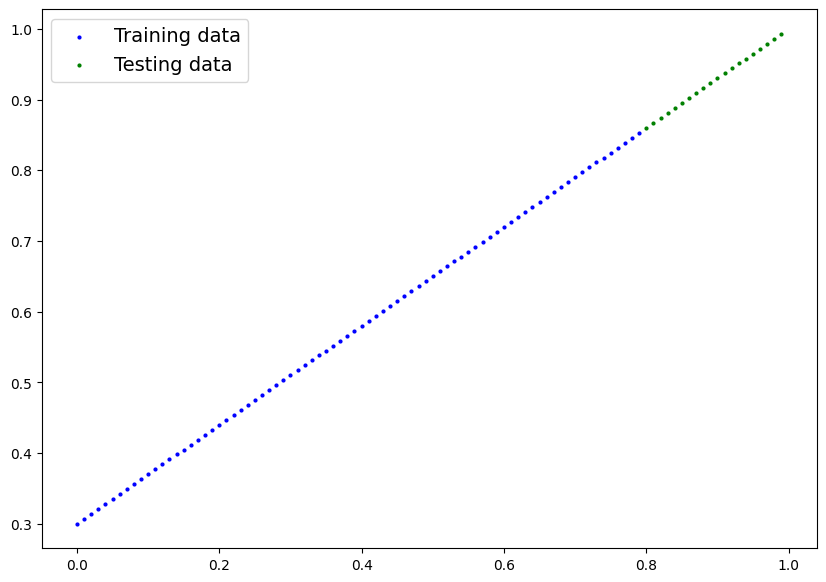

In [71]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a stright line

In [72]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
# Loss and optimizer

loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [74]:
# train loop
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# train loop
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # print 
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
    

Epoch 0 | Loss: 0.75986 | Test Loss: 0.54143
Epoch 100 | Loss: 0.09309 | Test Loss: 0.02901
Epoch 200 | Loss: 0.07376 | Test Loss: 0.02850
Epoch 300 | Loss: 0.06745 | Test Loss: 0.00615
Epoch 400 | Loss: 0.06107 | Test Loss: 0.02004
Epoch 500 | Loss: 0.05698 | Test Loss: 0.01061
Epoch 600 | Loss: 0.04857 | Test Loss: 0.01326
Epoch 700 | Loss: 0.06109 | Test Loss: 0.02127
Epoch 800 | Loss: 0.05599 | Test Loss: 0.01426
Epoch 900 | Loss: 0.05571 | Test Loss: 0.00603


In [ ]:
# turn on evalutaion

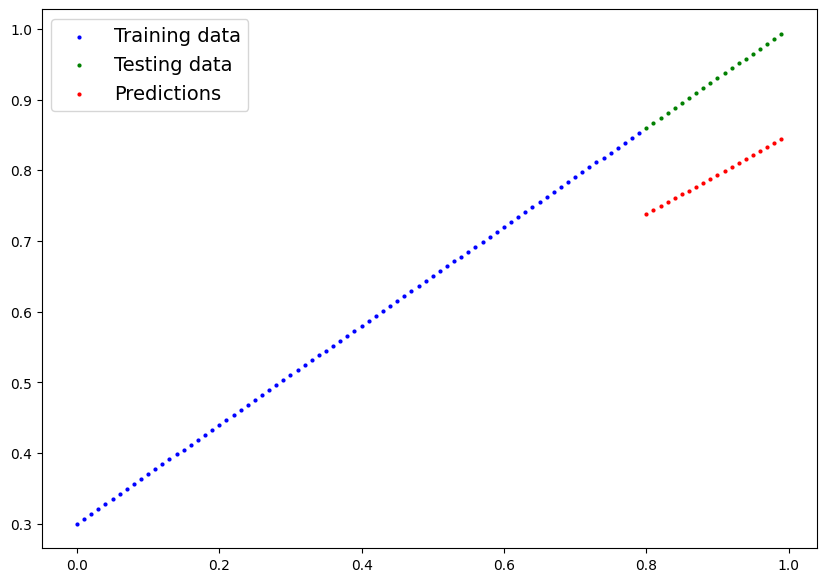

In [76]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

### 6 The missing piece: Non linearity

#### 6.1 recreating non linear data

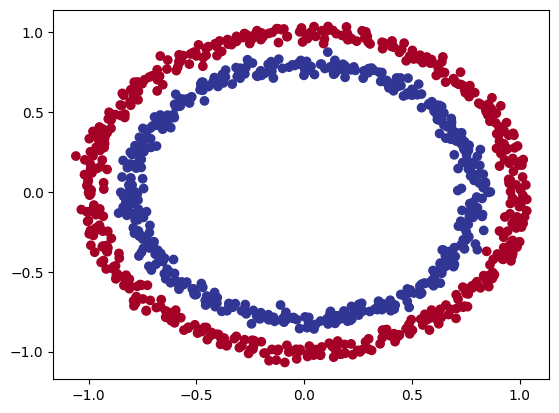

In [133]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [134]:
# Convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split


X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

X_train[:5],y_train[:5]

(tensor([[-0.0597, -0.9970],
         [-0.5320,  0.5567],
         [ 0.9656, -0.4018],
         [ 0.0764,  0.7993],
         [ 0.6488,  0.4942]]),
 tensor([0., 1., 0., 1., 1.]))

In [135]:
### 6.2 building a model with non linearity ( E finalmente)
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [136]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222,

![](image/02-tensorflow-playground-relu-activation.png)

In [137]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.3)

In [138]:
### 6.3 training a model with non linearity

torch.manual_seed(42)
torch.mps.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


epochs = 1000

for epoch in range(epochs):
    ### training
    model_3.train()

    # 1 forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # raw logits -> prediction probs -> prediction labels

    # 2. Loss & accuracyabs
    loss = loss_fn(y_logits, y_train)
    acc = acuracy_fn(y_train, y_pred)

    # 3 .Optimizer zero grad
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. Optimizer
    optimizer.step()

    ### Testing

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc {test_acc:.2f}%")

Epoch 0 | Loss 0.69286 | Acc: 52.00% | Test Loss: 0.69295 | Test Acc 49.50%
Epoch 100 | Loss 0.67718 | Acc: 57.00% | Test Loss: 0.68822 | Test Acc 52.00%
Epoch 200 | Loss 0.64405 | Acc: 60.50% | Test Loss: 0.67739 | Test Acc 54.12%
Epoch 300 | Loss 0.56000 | Acc: 81.50% | Test Loss: 0.60340 | Test Acc 77.75%
Epoch 400 | Loss 0.63838 | Acc: 53.00% | Test Loss: 0.86096 | Test Acc 53.12%
Epoch 500 | Loss 0.30706 | Acc: 85.50% | Test Loss: 0.37902 | Test Acc 80.00%
Epoch 600 | Loss 0.11076 | Acc: 99.00% | Test Loss: 0.12471 | Test Acc 99.12%
Epoch 700 | Loss 0.05255 | Acc: 100.00% | Test Loss: 0.06563 | Test Acc 99.62%
Epoch 800 | Loss 0.03523 | Acc: 100.00% | Test Loss: 0.04722 | Test Acc 99.50%
Epoch 900 | Loss 0.02668 | Acc: 100.00% | Test Loss: 0.03747 | Test Acc 99.62%


### 6.4 Evaluating a model trianed with non -linear activation functions

In [139]:
# Makes prediction

model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

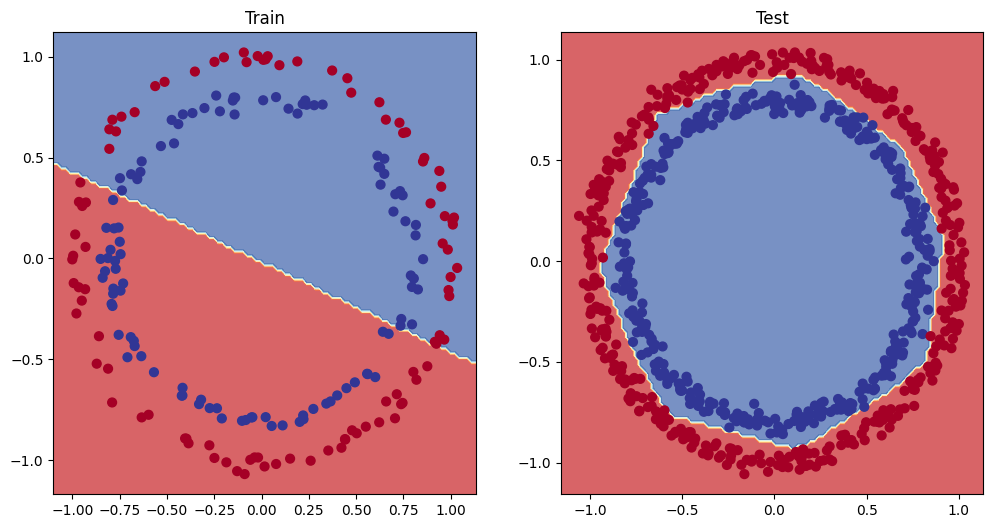

In [140]:
# plot decision bounderies

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model 1 no non linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model 3 has non linearity

### 7. Replicating non linear Activation function

Le reti neurali funzionano con una combinazione di funzioni lineari e non lineari.